In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import os
import shutil
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import t
import collections
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for progress tracking

from keras_tuner.tuners import Hyperband, RandomSearch, GridSearch
from keras_tuner import HyperModel
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Embedding, Flatten, concatenate, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm
from urllib3.exceptions import NotOpenSSLWarning

# Suppress specific categories of warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set seed for reproducibility across numpy and TensorFlow
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
file_path = '/Users/chesneycheyenne/Coding/Advanced Machine Learning/data/EURUSD_M30.csv'

eurusd = pd.read_csv(file_path, sep='\t')

# rename columns to open high low close volume
eurusd.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'nil']

eurusd = eurusd.drop(columns=['Volume','nil'])

eurusd.index = pd.to_datetime(eurusd.index)
print(eurusd)

                        Open     High      Low    Close
2008-03-20 03:30:00  1.55818  1.55988  1.55771  1.55945
2008-03-20 04:00:00  1.55959  1.56074  1.55909  1.56046
2008-03-20 04:30:00  1.56055  1.56079  1.55915  1.55955
2008-03-20 05:00:00  1.55950  1.55981  1.55838  1.55867
2008-03-20 05:30:00  1.55876  1.55960  1.55829  1.55943
...                      ...      ...      ...      ...
2024-03-28 19:30:00  1.07884  1.07892  1.07867  1.07879
2024-03-28 20:00:00  1.07878  1.07880  1.07849  1.07874
2024-03-28 20:30:00  1.07876  1.07887  1.07864  1.07883
2024-03-28 21:00:00  1.07897  1.07904  1.07849  1.07888
2024-03-28 21:30:00  1.07887  1.07901  1.07881  1.07893

[200000 rows x 4 columns]


In [14]:
eurusd['log_returns'] = np.log(eurusd['Close'] / eurusd['Close'].shift(1))
# Extract the date and the minute of the day
eurusd['date'] = eurusd.index.date
eurusd['time'] = eurusd.index.time

eurusd['squared_return'] = eurusd['log_returns']  ** 2

# drop nan from eurusd
eurusd.dropna(inplace=True)

daily_mean_squared_return = eurusd['squared_return'].resample('D').sum()
standardized_volatility = daily_mean_squared_return 

# print(len(daily_mean_squared_return))

# Drop weekends
standardized_volatility = standardized_volatility[standardized_volatility.index.dayofweek < 5]

# Identify dates where the value is exactly zero
dates_with_zero = standardized_volatility[standardized_volatility == 0].index

# print(dates_with_zero)
#drop zero values 
standardized_volatility = standardized_volatility[standardized_volatility > 0]

daily_volatility = np.log(standardized_volatility)

daily_volatility.index = daily_volatility.index.date

# do fill the Nan values with the mean of the series
Realized_vol = daily_volatility

print(f'number of data points: {len(Realized_vol)}')


number of data points: 4179


In [15]:
# Winsorize the data
Realized_vol_winsorized = winsorize(Realized_vol, limits=[0.001, 0.001])
RV = pd.Series(Realized_vol_winsorized, index=Realized_vol.index)

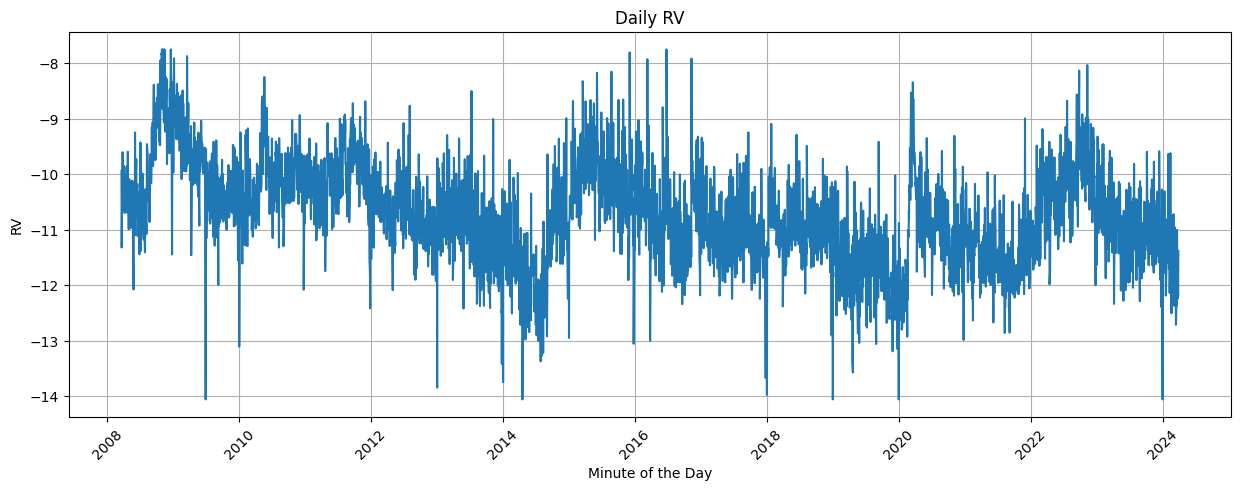

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(RV)
plt.title('Daily RV')
plt.xlabel('Minute of the Day')
plt.ylabel('RV')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [17]:
# Assuming 'RV' is your time series data
RV_df = RV.to_frame(name='RV_daily')  # Convert the RV Series into a DataFrame
RV_df['RV_weekly'] = RV_df['RV_daily'].rolling(window=5).mean()
RV_df['RV_monthly'] = RV_df['RV_daily'].rolling(window=21).mean()
RV_df['RV_daily_tomorrow'] = RV_df['RV_daily'].shift(-1)
RV_df.index = pd.to_datetime(RV_df.index)
RV_df['weekday'] = RV_df.index.weekday  # Monday=0, Sunday=6
RV_df['month'] = RV_df.index.month 

# Drop rows with NaN values
RV_df.dropna(inplace=True)


# Split data into training, validation, and holdout sets
train_size = int(len(RV_df) * 0.70)
val_size = int(len(RV_df) * 0.15)
holdout_size = len(RV_df) - train_size - val_size

train_data = RV_df.iloc[:train_size]
val_data = RV_df.iloc[train_size:train_size + val_size]
holdout_data = RV_df.iloc[train_size + val_size:]



print(f"The training set consists of {len(train_data)} data points from {train_data.index[0].date()} to {train_data.index[-1].date()}.")
print(f"The validation set consists of {len(val_data)} data points from {val_data.index[0].date()} to {val_data.index[-1].date()}.")
print(f"The holdout set consists of {len(holdout_data)} data points from {holdout_data.index[0].date()} to {holdout_data.index[-1].date()}.")


The training set consists of 2910 data points from 2008-04-17 to 2019-06-13.
The validation set consists of 623 data points from 2019-06-14 to 2021-11-03.
The holdout set consists of 625 data points from 2021-11-04 to 2024-03-27.


In [18]:
train_rv = train_data['RV_daily']
val_rv = val_data['RV_daily']
holdout_rv = holdout_data['RV_daily']

In [19]:
# DEFINE MEAN SQUARED ERROR FUNCTION
def MSE(y_true, y_pred):
    """
    Compute Mean Squared Error between two arrays.
    """
    return np.mean((y_true - y_pred) ** 2)

def q_like(y_true, y_pred):
    """
    Calculate the Quasi-likelihood (QLIKE).
    
    :param actual: numpy array of actual values.
    :param predicted: numpy array of predicted values.
    :return: QLIKE value.
    """
    ratio = y_true / y_pred
    return np.mean(ratio - np.log(ratio) - 1)

In [20]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_val = pd.DataFrame(columns=['Model', 'Val MSE', 'Val QLike'])

perf_holdout = pd.DataFrame(columns=['Model', 'Test MSE', 'Test QLike'])

# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_val
# FOR EASY COMPARISON LATER
def val_metrics(y_true, y_pred, model_name):
    perf_val.loc[len(perf_val.index)] = [model_name, 
                                       MSE(y_true, y_pred), 
                                       q_like(y_true, y_pred)]
    return perf_val

def holdout_metrics(y_true, y_pred, model_name):
    perf_holdout.loc[len(perf_holdout.index)] = [model_name, 
                                       MSE(y_true, y_pred), 
                                       q_like(y_true, y_pred)]
    return perf_holdout

In [183]:
def plot_predictions_and_residuals(actual, predicted):
    """
    Plots actual vs. predicted values and the residuals.
    
    Parameters:
    - actual: Array of actual target values.
    - predicted: Array of predicted values by the model.
    """
    plt.figure(figsize=(14, 6))
    
    # Actual vs. Predicted Values Plot
    plt.subplot(1, 2, 1)
    plt.plot(actual, label='Actual', linewidth=2)
    plt.plot(predicted, label='Predicted', linewidth=2)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    
    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = actual - predicted
    plt.plot(residuals, label='Residuals', color='red')
    plt.title('Residuals (Actual - Predicted)')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.axhline(y=0, color='black', linestyle='--')  # Zero line for reference
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Distribution of Predicted vs. Actual Values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(actual, bins=50, alpha=0.5, label='Actual')
    plt.hist(predicted, bins=50, alpha=0.5, label='Predicted')
    plt.title('Distribution of Actual and Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Density Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(actual, label='Actual', fill=True)
    sns.kdeplot(predicted, label='Predicted', fill=True)
    plt.title('Density of Actual and Predicted Values')
    plt.xlabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [184]:
# Function to fit GMM-HMM to daily RV data
def fit_gmm_hmm(data, n_components=4, n_mix=2, random_state=RANDOM_SEED):
    model = GMMHMM(n_components=n_components, n_mix=n_mix, covariance_type="full", n_iter=1000, random_state=random_state)
    model.fit(data)
    return model


In [185]:
# Function to generate hidden states and emission probabilities
def generate_hmm_features(hmm_model, data):
    hidden_states = hmm_model.predict(data)
    emission_probs = hmm_model.predict_proba(data)
    return hidden_states, emission_probs


In [186]:
# Function to calculate the product of mean and variance for each state
def calculate_state_measures(hmm_model):
    state_measures = []
    for state in range(hmm_model.n_components):
        means = hmm_model.means_[state]  # Means for the current state
        covars = hmm_model.covars_[state]  # Covariances for the current state

        # Calculate the variance (diagonal of the covariance matrix)
        variances = np.diagonal(covars, axis1=0, axis2=1)

        # Calculate the product of mean and variance
        product = means * variances

        # Calculate the mean of the product
        product_mean = np.mean(product)

        # Append the state index and the product mean to the list
        state_measures.append((state, product_mean))

    # Sort the states based on the product mean in descending order
    state_measures.sort(key=lambda x: x[1], reverse=True)

    return state_measures


In [187]:
# Function to label the states based on sorted measures
def label_states(state_measures):
    labels = ['Bear', 'Transition Bear', 'Transition Bull', 'Bull']
    state_labels = {state: label for (state, _), label in zip(state_measures, labels)}
    return state_labels


In [188]:
# Function to calculate expected mean and standard deviation for GMM-HMM
def calculate_expected_values(hmm_model, state_probs):
    n_components, n_mix = hmm_model.n_components, hmm_model.n_mix
    means = hmm_model.means_
    covars = hmm_model.covars_

    E_mean = 0
    E_var = 0
    for i in range(n_components):
        for j in range(n_mix):
            weight = state_probs[i] * hmm_model.weights_[i, j]
            mean = means[i, j]
            covar = np.diagonal(covars[i, j])
            E_mean += weight * mean
            E_var += weight * (mean**2 + covar)

    E_var -= E_mean**2
    E_std = np.sqrt(E_var)
    
    return E_mean, E_std


In [189]:
# Function to calculate long-term probabilities
def calculate_long_term_probabilities(hmm_model, state_probs, tol=1e-10):
    A = hmm_model.transmat_
    print(f"Transition Matrix A:\n{A}")

    # Normalize state probabilities
    state_probs = state_probs / state_probs.sum()

    # Calculate the stationary distribution
    eigvals, eigvecs = np.linalg.eig(A.T)
    stationary_dist = eigvecs[:, np.isclose(eigvals, 1)]
    stationary_dist = stationary_dist / stationary_dist.sum()
    stationary_dist = stationary_dist.real

    print(f"Stationary Distribution for current step:\n{stationary_dist.flatten()}")
    return stationary_dist.flatten()


In [168]:
# Initialize the model with seed data
seed_size = 2889  # Number of initial seed data points
train_rv_seed = train_rv[:seed_size]

# Scale the seed data
scaler = StandardScaler()
train_scaled_seed = scaler.fit_transform(train_rv_seed.values.reshape(-1, 1))

# Lists to store results
expected_means = []
expected_stds = []
long_term_probs = []
state_probs = []
state_labels_list = []

# Retrain model iteratively by adding one new data point each day
for i in tqdm(range(seed_size, len(train_rv)), desc="Retraining Model"):
    current_data = train_rv[:i+1]
    current_scaled = scaler.transform(current_data.values.reshape(-1, 1))
    
    gmm_hmm_model = fit_gmm_hmm(current_scaled)
    hidden_states, emission_probs = generate_hmm_features(gmm_hmm_model, current_scaled)
    
    # Calculate expected mean and standard deviation for the current window
    print(emission_probs[-1])
    E_mean, E_std = calculate_expected_values(gmm_hmm_model, emission_probs[-1])
    expected_means.append(E_mean)
    expected_stds.append(E_std)
    
    # Calculate the long-term probabilities for the current window
    p_LT = calculate_long_term_probabilities(gmm_hmm_model, emission_probs[-1])
    long_term_probs.append(p_LT)
    
    # Store the state probabilities and state labels
    state_probs.append(emission_probs[-1])
    state_measures = calculate_state_measures(gmm_hmm_model)
    state_labels = label_states(state_measures)
    state_labels_list.append(state_labels)
    print(state_labels)


Retraining Model:   5%|▍         | 1/21 [00:02<00:46,  2.32s/it]

[2.01436609e-03 9.00025195e-13 9.97982616e-01 3.01812710e-06]
Transition Matrix A:
[[9.67631036e-001 2.32668639e-056 1.69555181e-002 1.54134460e-002]
 [4.44685931e-120 9.46414224e-001 1.57931076e-220 5.35857757e-002]
 [2.06547167e-002 4.28343947e-004 9.78869401e-001 4.75382524e-005]
 [2.92755523e-002 1.62597854e-002 1.52260192e-003 9.52942060e-001]]
Stationary Distribution for current step:
[0.39755846 0.06460504 0.33371534 0.20412116]
{1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}


Retraining Model:  10%|▉         | 2/21 [00:04<00:40,  2.14s/it]

[4.20159855e-03 3.22662847e-12 6.73351628e-06 9.95791668e-01]
Transition Matrix A:
[[9.69893377e-001 5.14655028e-099 2.35031597e-002 6.60346361e-003]
 [9.89386890e-199 9.65868109e-001 3.41318914e-002 2.49845380e-051]
 [1.89978888e-002 1.30543156e-002 9.67947796e-001 2.80490329e-112]
 [2.28744021e-002 1.77277112e-220 5.22444351e-011 9.77125598e-001]]
Stationary Distribution for current step:
[0.33344485 0.15777518 0.41251992 0.09626004]
{1: 'Bear', 2: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}


Retraining Model:  14%|█▍        | 3/21 [00:06<00:34,  1.93s/it]

[2.18700610e-06 7.63866004e-04 1.24101154e-14 9.99233947e-01]
Transition Matrix A:
[[9.67893044e-001 1.90394206e-002 1.30675358e-002 5.16995873e-116]
 [2.34886394e-002 9.69972047e-001 1.76027574e-097 6.53931333e-003]
 [3.42169911e-002 4.86252934e-201 9.65783009e-001 5.84857270e-056]
 [5.07260952e-012 2.26635255e-002 4.95607453e-226 9.77336475e-001]]
Stationary Distribution for current step:
[0.41213899 0.33407161 0.15739669 0.09639272]
{2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}


Retraining Model:  19%|█▉        | 4/21 [00:07<00:29,  1.76s/it]

[9.89831861e-01 2.53563529e-10 1.01160040e-02 5.21346489e-05]
Transition Matrix A:
[[9.79235140e-001 4.05850123e-005 1.94013865e-002 1.32288879e-003]
 [0.00000000e+000 9.50077633e-001 2.50449944e-168 4.99223667e-002]
 [1.64421854e-002 1.09996771e-075 9.68353533e-001 1.52042813e-002]
 [1.53670717e-003 1.53827012e-002 2.97370830e-002 9.53343509e-001]]
Stationary Distribution for current step:
[0.33027925 0.06428154 0.39769403 0.20774518]
{1: 'Bear', 3: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}


Retraining Model:  24%|██▍       | 5/21 [00:09<00:30,  1.89s/it]

[1.78907936e-05 4.85280644e-03 3.66303925e-13 9.95129303e-01]
Transition Matrix A:
[[9.67835272e-001 1.90837015e-002 1.30810262e-002 5.76213762e-120]
 [2.34893961e-002 9.70065105e-001 3.45408235e-099 6.44549916e-003]
 [3.42943092e-002 2.12074081e-203 9.65705691e-001 1.00399316e-059]
 [2.18519841e-012 2.20905896e-002 4.29652440e-230 9.77909410e-001]]
Stationary Distribution for current step:
[0.41136632 0.33421005 0.15690923 0.0975144 ]
{2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}


Retraining Model:  29%|██▊       | 6/21 [00:11<00:28,  1.90s/it]

[8.16488510e-03 1.69018118e-11 9.91814741e-01 2.03742860e-05]
Transition Matrix A:
[[9.66971291e-001 9.08726466e-083 1.68505736e-002 1.61781352e-002]
 [3.42500854e-173 9.47563947e-001 3.34482442e-321 5.24360533e-002]
 [1.94168726e-002 3.08245612e-006 9.79739015e-001 8.41030243e-004]
 [3.13028436e-002 1.61270412e-002 6.45881857e-023 9.52570115e-001]]
Stationary Distribution for current step:
[0.39419291 0.06539648 0.32784075 0.21256985]
{1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}


Retraining Model:  33%|███▎      | 7/21 [00:12<00:23,  1.64s/it]

[2.09170120e-05 9.75056153e-01 5.07689796e-11 2.49229298e-02]
Transition Matrix A:
[[9.60804576e-001 4.14499713e-118 1.62136880e-002 2.29817359e-002]
 [1.48457403e-039 9.80990304e-001 3.58250403e-179 1.90096962e-002]
 [4.11813539e-002 5.72576915e-093 9.58818646e-001 1.21439309e-023]
 [2.64064371e-002 5.42587722e-003 1.06491710e-045 9.68167686e-001]]
Stationary Distribution for current step:
[0.39802077 0.09887205 0.15670647 0.3464007 ]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model:  38%|███▊      | 8/21 [00:14<00:21,  1.62s/it]

[9.75113081e-08 9.97253006e-01 8.00774116e-15 2.74689669e-03]
Transition Matrix A:
[[9.60862902e-001 1.26088862e-116 1.61923993e-002 2.29446991e-002]
 [1.32800120e-039 9.81318405e-001 2.70833961e-173 1.86815953e-002]
 [4.11258674e-002 2.61487386e-087 9.58874133e-001 2.29484612e-023]
 [2.63591753e-002 5.36575257e-003 1.96382861e-044 9.68275072e-001]]
Stationary Distribution for current step:
[0.39773973 0.09944116 0.15660121 0.3462179 ]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model:  43%|████▎     | 9/21 [00:16<00:20,  1.67s/it]

[5.83982508e-07 9.95060525e-01 3.83963030e-14 4.93889078e-03]
Transition Matrix A:
[[9.60815015e-001 1.17211575e-113 1.62249708e-002 2.29600145e-002]
 [3.06592580e-039 9.81243768e-001 1.38239533e-170 1.87562316e-002]
 [4.11986233e-002 7.23998420e-087 9.58801377e-001 5.94154686e-023]
 [2.63625804e-002 5.38898851e-003 1.14066495e-043 9.68248431e-001]]
Stationary Distribution for current step:
[0.39761607 0.09949697 0.15659041 0.34629656]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model:  48%|████▊     | 10/21 [00:18<00:20,  1.87s/it]

[7.04738396e-14 2.72449448e-03 1.38599614e-06 9.97274120e-01]
Transition Matrix A:
[[9.65981053e-001 2.30988493e-193 3.40189467e-002 3.20700308e-047]
 [1.17207532e-093 9.70092640e-001 2.34002942e-002 6.50706594e-003]
 [1.30385558e-002 1.88858984e-002 9.68075546e-001 9.30326819e-107]
 [8.80420639e-208 2.18228324e-002 1.62487003e-010 9.78177167e-001]]
Stationary Distribution for current step:
[0.15766043 0.33199413 0.41135244 0.098993  ]
{0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}


Retraining Model:  52%|█████▏    | 11/21 [00:20<00:19,  1.99s/it]

[1.09594209e-03 1.89818688e-14 9.01278488e-07 9.98903157e-01]
Transition Matrix A:
[[9.70138805e-001 3.89150774e-103 2.34347057e-002 6.42648948e-003]
 [6.90713508e-205 9.65786046e-001 3.42139541e-002 2.63028365e-059]
 [1.90332419e-002 1.30624313e-002 9.67904327e-001 5.85770088e-127]
 [2.16368492e-002 1.32643587e-228 6.89750580e-013 9.78363151e-001]]
Stationary Distribution for current step:
[0.33351758 0.1567784  0.41064398 0.09906004]
{1: 'Bear', 2: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}


Retraining Model:  57%|█████▋    | 12/21 [00:23<00:19,  2.20s/it]

[5.72421305e-02 1.00829662e-10 1.80920629e-05 9.42739777e-01]
Transition Matrix A:
[[9.71484696e-001 4.28287896e-109 2.25296957e-002 5.98560868e-003]
 [2.80623988e-038 9.65164172e-001 3.48358276e-002 1.98409368e-198]
 [1.89225431e-002 1.31767797e-002 9.67900677e-001 2.26239012e-247]
 [2.05875496e-002 0.00000000e+000 1.89935169e-094 9.79412450e-001]]
Stationary Distribution for current step:
[0.34109604 0.15361572 0.40611824 0.09917001]
{1: 'Bear', 2: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}


Retraining Model:  62%|██████▏   | 13/21 [00:25<00:17,  2.19s/it]

[7.49715866e-04 1.83860537e-01 2.12240058e-09 8.15389745e-01]
Transition Matrix A:
[[9.67801785e-001 1.91010605e-002 1.30971550e-002 1.61322420e-122]
 [2.34214645e-002 9.70224459e-001 3.46509280e-099 6.35407655e-003]
 [3.43789331e-002 1.27014688e-203 9.65621067e-001 4.83420973e-059]
 [2.90279604e-012 2.17783146e-002 2.73708748e-228 9.78221685e-001]]
Stationary Distribution for current step:
[0.41077152 0.33499919 0.15648939 0.09773991]
{2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}


Retraining Model:  67%|██████▋   | 14/21 [00:26<00:13,  1.97s/it]

[9.81155400e-03 1.87044236e-12 9.90160361e-01 2.80853388e-05]
Transition Matrix A:
[[9.67683502e-001 1.51993869e-060 1.63984875e-002 1.59180104e-002]
 [1.27599878e-129 9.46815484e-001 4.05002161e-274 5.31845164e-002]
 [1.87985204e-002 2.62156605e-025 9.79920723e-001 1.28075652e-003]
 [3.13022127e-002 1.63689580e-002 2.88070357e-085 9.52328829e-001]]
Stationary Distribution for current step:
[0.39597272 0.06604714 0.32338584 0.2145943 ]
{1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}


Retraining Model:  71%|███████▏  | 15/21 [00:28<00:10,  1.83s/it]

[6.69691209e-02 9.65907257e-10 9.32377035e-01 6.53843272e-04]
Transition Matrix A:
[[9.67569133e-001 3.49860719e-060 1.64765704e-002 1.59542969e-002]
 [4.22944152e-129 9.46878772e-001 3.32439716e-273 5.31212281e-002]
 [1.88139727e-002 1.23972969e-025 9.79925011e-001 1.26101669e-003]
 [3.13245241e-002 1.63553353e-002 5.25670733e-085 9.52320141e-001]]
Stationary Distribution for current step:
[0.3952411  0.06599999 0.32439458 0.21436434]
{1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}


Retraining Model:  76%|███████▌  | 16/21 [00:30<00:09,  1.83s/it]

[1.00897766e-01 8.51013778e-01 7.28129022e-05 4.80156428e-02]
Transition Matrix A:
[[9.67997327e-001 1.89546789e-002 1.30479945e-002 4.66686698e-108]
 [2.34621285e-002 9.69598439e-001 5.61350112e-094 6.93943230e-003]
 [3.40823700e-002 2.87549852e-197 9.65917630e-001 1.90795447e-051]
 [1.77029999e-012 2.74538179e-002 3.72663999e-218 9.72546182e-001]]
Stationary Distribution for current step:
[0.4175491  0.33733125 0.15985327 0.08526637]
{2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}


Retraining Model:  81%|████████  | 17/21 [00:31<00:07,  1.78s/it]

[2.23953744e-01 7.06761016e-03 2.06293588e-04 7.68772353e-01]
Transition Matrix A:
[[9.67984598e-001 8.23162192e-132 1.26374290e-002 1.93779732e-002]
 [5.69034568e-003 9.69255524e-001 4.43942448e-170 2.50541305e-002]
 [3.11111902e-002 1.83187278e-003 9.67056937e-001 6.68129428e-189]
 [2.24753225e-002 6.62848964e-003 6.60966786e-108 9.70896188e-001]]
Stationary Distribution for current step:
[0.41157872 0.08409872 0.15788747 0.34643509]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model:  86%|████████▌ | 18/21 [00:33<00:05,  1.87s/it]

[1.30439443e-02 2.69884358e-02 1.28886184e-06 9.59966331e-01]
Transition Matrix A:
[[9.67951785e-001 1.16630721e-287 1.31749003e-002 1.88733149e-002]
 [3.08041844e-128 9.73299772e-001 0.00000000e+000 2.67002277e-002]
 [3.48347760e-002 4.27215416e-199 9.65165224e-001 6.26984131e-055]
 [2.23320192e-002 6.47910056e-003 8.93607944e-135 9.71188880e-001]]
Stationary Distribution for current step:
[0.41179155 0.08444956 0.15574415 0.34801473]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model:  90%|█████████ | 19/21 [00:35<00:03,  1.75s/it]

[9.90859472e-01 1.70850044e-05 9.12344340e-03 7.04112299e-12]
Transition Matrix A:
[[9.79603702e-001 1.44658364e-010 2.01206233e-002 2.75674767e-004]
 [1.47835130e-003 9.53306309e-001 2.88665526e-002 1.63487867e-002]
 [1.62118828e-002 1.51496687e-002 9.68638448e-001 3.26091069e-078]
 [3.76108313e-317 5.30875317e-002 8.64428142e-169 9.46912468e-001]]
Stationary Distribution for current step:
[0.33279433 0.20282091 0.40019608 0.06418868]
{3: 'Bear', 1: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}


Retraining Model:  95%|█████████▌| 20/21 [00:36<00:01,  1.54s/it]

[6.09459706e-04 3.49478006e-01 1.88798075e-09 6.49912533e-01]
Transition Matrix A:
[[9.60661354e-001 1.06988653e-074 1.63664164e-002 2.29722292e-002]
 [1.18885804e-029 9.76097962e-001 1.44576526e-115 2.39020379e-002]
 [4.14768148e-002 5.08325072e-058 9.58523185e-001 5.70395705e-020]
 [2.62060473e-002 6.01140287e-003 1.92738146e-033 9.67782550e-001]]
Stationary Distribution for current step:
[0.40133908 0.0884818  0.15836516 0.35181396]
{2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}


Retraining Model: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]

[2.32528533e-04 5.39595608e-10 9.99767471e-01 6.35785795e-83]
Transition Matrix A:
[[9.65936405e-01 1.42095472e-02 1.90837235e-02 7.70323799e-04]
 [2.87837885e-02 9.69466897e-01 1.46022306e-47 1.74931413e-03]
 [1.73075895e-02 6.72884821e-44 9.77825576e-01 4.86683495e-03]
 [7.45875126e-01 1.83995015e-30 2.54124874e-01 3.21661010e-74]]
Stationary Distribution for current step:
[0.41628829 0.19373295 0.3874336  0.00254515]
{1: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 2: 'Bull'}


In [179]:
# Initialize the model with seed data
seed_size = 2889  # Number of initial seed data points
train_rv_seed = train_rv[:seed_size]

# Scale the seed data
scaler = StandardScaler()
train_scaled_seed = scaler.fit_transform(train_rv_seed.values.reshape(-1, 1))

# Lists to store results
expected_means = []
expected_stds = []
long_term_probs = []
state_probs = []
state_labels_list = []

# Retrain model iteratively by adding one new data point each day
for i in tqdm(range(seed_size, len(train_rv)), desc="Retraining Model"):
    current_data = train_rv[:i+1]
    current_scaled = scaler.transform(current_data.values.reshape(-1, 1))
    
    gmm_hmm_model = fit_gmm_hmm(current_scaled)
    hidden_states, emission_probs = generate_hmm_features(gmm_hmm_model, current_scaled)
    
    # Calculate expected mean and standard deviation for the current window
    print(emission_probs[-1])
    E_mean, E_std = calculate_expected_values(gmm_hmm_model, emission_probs[-1])
    expected_means.append(E_mean)
    expected_stds.append(E_std)
    
    # Calculate the long-term probabilities for the current window
    p_LT = calculate_long_term_probabilities(gmm_hmm_model, emission_probs[-1])
    
    # Get state labels and reorder them
    state_measures = calculate_state_measures(gmm_hmm_model)
    state_labels = label_states(state_measures)
    print("State labels before ordering:", state_labels)
    
    # Create a consistent order: Bear, Transition Bear, Transition Bull, Bull
    ordered_labels = ['Bear', 'Transition Bear', 'Transition Bull', 'Bull']
    label_order = {v: k for k, v in state_labels.items()}
    
    # Reorder state_probs and p_LT
    ordered_state_probs = [emission_probs[-1][label_order[label]] for label in ordered_labels]
    ordered_long_term_probs = [p_LT[label_order[label]] for label in ordered_labels]
    
    # Append reordered probabilities
    state_probs.append(ordered_state_probs)
    print("State probs after ordering:", ordered_long_term_probs)


    long_term_probs.append(ordered_long_term_probs)
    
    # Store the ordered state labels
    state_labels_list.append({i: ordered_labels[i] for i in range(len(ordered_labels))})

# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Mean': expected_means,
    'Expected_STD': expected_stds,
    'State_Probs': state_probs,
    'Long_Term_Probs': long_term_probs,
    'State_Labels': state_labels_list
})

print("Results DF:\n", results_df.head(10))




Retraining Model:   5%|▍         | 1/21 [00:03<01:04,  3.22s/it]

[2.01436609e-03 9.00025195e-13 9.97982616e-01 3.01812710e-06]
Transition Matrix A:
[[9.67631036e-001 2.32668639e-056 1.69555181e-002 1.54134460e-002]
 [4.44685931e-120 9.46414224e-001 1.57931076e-220 5.35857757e-002]
 [2.06547167e-002 4.28343947e-004 9.78869401e-001 4.75382524e-005]
 [2.92755523e-002 1.62597854e-002 1.52260192e-003 9.52942060e-001]]
Stationary Distribution for current step:
[0.39755846 0.06460504 0.33371534 0.20412116]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.20412116252242934, 0.06460504101253348, 0.3975584597255461, 0.3337153367394911]


Retraining Model:  10%|▉         | 2/21 [00:05<00:45,  2.40s/it]

[4.20159855e-03 3.22662847e-12 6.73351628e-06 9.95791668e-01]
Transition Matrix A:
[[9.69893377e-001 5.14655028e-099 2.35031597e-002 6.60346361e-003]
 [9.89386890e-199 9.65868109e-001 3.41318914e-002 2.49845380e-051]
 [1.89978888e-002 1.30543156e-002 9.67947796e-001 2.80490329e-112]
 [2.28744021e-002 1.77277112e-220 5.22444351e-011 9.77125598e-001]]
Stationary Distribution for current step:
[0.33344485 0.15777518 0.41251992 0.09626004]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41251992335579135, 0.15777517897127977, 0.3334448535702825, 0.09626004410264641]


Retraining Model:  14%|█▍        | 3/21 [00:07<00:39,  2.20s/it]

[2.18700610e-06 7.63866004e-04 1.24101154e-14 9.99233947e-01]
Transition Matrix A:
[[9.67893044e-001 1.90394206e-002 1.30675358e-002 5.16995873e-116]
 [2.34886394e-002 9.69972047e-001 1.76027574e-097 6.53931333e-003]
 [3.42169911e-002 4.86252934e-201 9.65783009e-001 5.84857270e-056]
 [5.07260952e-012 2.26635255e-002 4.95607453e-226 9.77336475e-001]]
Stationary Distribution for current step:
[0.41213899 0.33407161 0.15739669 0.09639272]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15739668512442492, 0.4121389858048329, 0.33407160703210653, 0.09639272203863572]


Retraining Model:  19%|█▉        | 4/21 [00:08<00:31,  1.85s/it]

[9.89831861e-01 2.53563529e-10 1.01160040e-02 5.21346489e-05]
Transition Matrix A:
[[9.79235140e-001 4.05850123e-005 1.94013865e-002 1.32288879e-003]
 [0.00000000e+000 9.50077633e-001 2.50449944e-168 4.99223667e-002]
 [1.64421854e-002 1.09996771e-075 9.68353533e-001 1.52042813e-002]
 [1.53670717e-003 1.53827012e-002 2.97370830e-002 9.53343509e-001]]
Stationary Distribution for current step:
[0.33027925 0.06428154 0.39769403 0.20774518]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}
State probs after ordering: [0.2077451770952222, 0.06428153536969657, 0.39769403487805194, 0.33027925265702934]


Retraining Model:  24%|██▍       | 5/21 [00:09<00:28,  1.77s/it]

[1.78907936e-05 4.85280644e-03 3.66303925e-13 9.95129303e-01]
Transition Matrix A:
[[9.67835272e-001 1.90837015e-002 1.30810262e-002 5.76213762e-120]
 [2.34893961e-002 9.70065105e-001 3.45408235e-099 6.44549916e-003]
 [3.42943092e-002 2.12074081e-203 9.65705691e-001 1.00399316e-059]
 [2.18519841e-012 2.20905896e-002 4.29652440e-230 9.77909410e-001]]
Stationary Distribution for current step:
[0.41136632 0.33421005 0.15690923 0.0975144 ]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41136632442414545, 0.15690923097169998, 0.3342100456824096, 0.09751439892174503]


Retraining Model:  29%|██▊       | 6/21 [00:11<00:24,  1.66s/it]

[8.16488510e-03 1.69018118e-11 9.91814741e-01 2.03742860e-05]
Transition Matrix A:
[[9.66971291e-001 9.08726466e-083 1.68505736e-002 1.61781352e-002]
 [3.42500853e-173 9.47563947e-001 3.34482442e-321 5.24360533e-002]
 [1.94168726e-002 3.08245612e-006 9.79739015e-001 8.41030243e-004]
 [3.13028436e-002 1.61270412e-002 6.45881857e-023 9.52570115e-001]]
Stationary Distribution for current step:
[0.39419291 0.06539648 0.32784075 0.21256985]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.21256985144140547, 0.06539647996030695, 0.3941929140683682, 0.3278407545299193]


Retraining Model:  33%|███▎      | 7/21 [00:12<00:20,  1.47s/it]

[2.09170120e-05 9.75056153e-01 5.07689796e-11 2.49229298e-02]
Transition Matrix A:
[[9.60804576e-001 4.14499713e-118 1.62136880e-002 2.29817359e-002]
 [1.48457403e-039 9.80990304e-001 3.58250403e-179 1.90096962e-002]
 [4.11813539e-002 5.72576915e-093 9.58818646e-001 1.21439309e-023]
 [2.64064371e-002 5.42587722e-003 1.06491710e-045 9.68167686e-001]]
Stationary Distribution for current step:
[0.39802077 0.09887205 0.15670647 0.3464007 ]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.1567064712272775, 0.39802077444906786, 0.3464007018909484, 0.09887205243270623]


Retraining Model:  38%|███▊      | 8/21 [00:13<00:18,  1.40s/it]

[9.75113081e-08 9.97253006e-01 8.00774116e-15 2.74689669e-03]
Transition Matrix A:
[[9.60862902e-001 1.26088862e-116 1.61923993e-002 2.29446991e-002]
 [1.32800120e-039 9.81318405e-001 2.70833961e-173 1.86815953e-002]
 [4.11258674e-002 2.61487386e-087 9.58874133e-001 2.29484612e-023]
 [2.63591753e-002 5.36575257e-003 1.96382861e-044 9.68275072e-001]]
Stationary Distribution for current step:
[0.39773973 0.09944116 0.15660121 0.3462179 ]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.156601206873601, 0.3977397274669302, 0.34621790126516155, 0.09944116439430714]


Retraining Model:  43%|████▎     | 9/21 [00:14<00:15,  1.31s/it]

[5.83982508e-07 9.95060525e-01 3.83963030e-14 4.93889078e-03]
Transition Matrix A:
[[9.60815015e-001 1.17211575e-113 1.62249708e-002 2.29600145e-002]
 [3.06592580e-039 9.81243768e-001 1.38239533e-170 1.87562316e-002]
 [4.11986233e-002 7.23998420e-087 9.58801377e-001 5.94154686e-023]
 [2.63625804e-002 5.38898851e-003 1.14066495e-043 9.68248431e-001]]
Stationary Distribution for current step:
[0.39761607 0.09949697 0.15659041 0.34629656]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.1565904061405955, 0.39761607128396875, 0.3462965555537167, 0.09949696702171912]


Retraining Model:  48%|████▊     | 10/21 [00:16<00:15,  1.37s/it]

[7.04738396e-14 2.72449448e-03 1.38599614e-06 9.97274120e-01]
Transition Matrix A:
[[9.65981053e-001 2.30988493e-193 3.40189467e-002 3.20700308e-047]
 [1.17207532e-093 9.70092640e-001 2.34002942e-002 6.50706594e-003]
 [1.30385558e-002 1.88858984e-002 9.68075546e-001 9.30326819e-107]
 [8.80420639e-208 2.18228324e-002 1.62487003e-010 9.78177167e-001]]
Stationary Distribution for current step:
[0.15766043 0.33199413 0.41135244 0.098993  ]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.1576604286839535, 0.411352438844793, 0.3319941307840189, 0.09899300168723459]


Retraining Model:  52%|█████▏    | 11/21 [00:17<00:13,  1.40s/it]

[1.09594209e-03 1.89818688e-14 9.01278488e-07 9.98903157e-01]
Transition Matrix A:
[[9.70138805e-001 3.89150774e-103 2.34347057e-002 6.42648948e-003]
 [6.90713508e-205 9.65786046e-001 3.42139541e-002 2.63028365e-059]
 [1.90332419e-002 1.30624313e-002 9.67904327e-001 5.85770088e-127]
 [2.16368492e-002 1.32643587e-228 6.89750580e-013 9.78363151e-001]]
Stationary Distribution for current step:
[0.33351758 0.1567784  0.41064398 0.09906004]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41064398444868, 0.1567783955172065, 0.33351757742899824, 0.0990600426051153]


Retraining Model:  57%|█████▋    | 12/21 [00:19<00:13,  1.53s/it]

[5.72421305e-02 1.00829662e-10 1.80920629e-05 9.42739777e-01]
Transition Matrix A:
[[9.71484696e-001 4.28287896e-109 2.25296957e-002 5.98560868e-003]
 [2.80623988e-038 9.65164172e-001 3.48358276e-002 1.98409368e-198]
 [1.89225431e-002 1.31767797e-002 9.67900677e-001 2.26239012e-247]
 [2.05875496e-002 0.00000000e+000 1.89935169e-094 9.79412450e-001]]
Stationary Distribution for current step:
[0.34109604 0.15361572 0.40611824 0.09917001]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.40611824161889853, 0.1536157160084026, 0.34109603735492056, 0.0991700050177783]


Retraining Model:  62%|██████▏   | 13/21 [00:21<00:12,  1.58s/it]

[7.49715866e-04 1.83860537e-01 2.12240058e-09 8.15389745e-01]
Transition Matrix A:
[[9.67801785e-001 1.91010605e-002 1.30971550e-002 1.61322420e-122]
 [2.34214645e-002 9.70224459e-001 3.46509280e-099 6.35407655e-003]
 [3.43789331e-002 1.27014688e-203 9.65621067e-001 4.83420974e-059]
 [2.90279604e-012 2.17783146e-002 2.73708749e-228 9.78221685e-001]]
Stationary Distribution for current step:
[0.41077152 0.33499919 0.15648939 0.09773991]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.1564893883547667, 0.41077151593770306, 0.33499918705274745, 0.0977399086547828]


Retraining Model:  67%|██████▋   | 14/21 [00:22<00:10,  1.44s/it]

[9.81155400e-03 1.87044236e-12 9.90160361e-01 2.80853388e-05]
Transition Matrix A:
[[9.67683502e-001 1.51993869e-060 1.63984875e-002 1.59180104e-002]
 [1.27599878e-129 9.46815484e-001 4.05002162e-274 5.31845164e-002]
 [1.87985204e-002 2.62156605e-025 9.79920723e-001 1.28075652e-003]
 [3.13022127e-002 1.63689580e-002 2.88070357e-085 9.52328829e-001]]
Stationary Distribution for current step:
[0.39597272 0.06604714 0.32338584 0.2145943 ]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.06604713820501663, 0.21459430080641945, 0.39597272414849377, 0.3233858368400701]


Retraining Model:  71%|███████▏  | 15/21 [00:23<00:08,  1.45s/it]

[6.69691209e-02 9.65907257e-10 9.32377035e-01 6.53843272e-04]
Transition Matrix A:
[[9.67569133e-001 3.49860719e-060 1.64765704e-002 1.59542969e-002]
 [4.22944152e-129 9.46878772e-001 3.32439716e-273 5.31212281e-002]
 [1.88139727e-002 1.23972969e-025 9.79925011e-001 1.26101669e-003]
 [3.13245241e-002 1.63553353e-002 5.25670733e-085 9.52320141e-001]]
Stationary Distribution for current step:
[0.3952411  0.06599999 0.32439458 0.21436434]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.06599999102863921, 0.21436433500306157, 0.39524109561587195, 0.32439457835242724]


Retraining Model:  76%|███████▌  | 16/21 [00:25<00:07,  1.49s/it]

[1.00897766e-01 8.51013778e-01 7.28129022e-05 4.80156428e-02]
Transition Matrix A:
[[9.67997327e-001 1.89546789e-002 1.30479945e-002 4.66686698e-108]
 [2.34621285e-002 9.69598439e-001 5.61350112e-094 6.93943230e-003]
 [3.40823700e-002 2.87549852e-197 9.65917630e-001 1.90795447e-051]
 [1.77029999e-012 2.74538179e-002 3.72663999e-218 9.72546182e-001]]
Stationary Distribution for current step:
[0.4175491  0.33733125 0.15985327 0.08526637]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41754910328810857, 0.15985327378691205, 0.33733125312878215, 0.08526636979619741]


Retraining Model:  81%|████████  | 17/21 [00:26<00:05,  1.48s/it]

[2.23953744e-01 7.06761016e-03 2.06293588e-04 7.68772353e-01]
Transition Matrix A:
[[9.67984598e-001 8.23162192e-132 1.26374290e-002 1.93779732e-002]
 [5.69034568e-003 9.69255524e-001 4.43942448e-170 2.50541305e-002]
 [3.11111902e-002 1.83187278e-003 9.67056937e-001 6.68129428e-189]
 [2.24753225e-002 6.62848964e-003 6.60966786e-108 9.70896188e-001]]
Stationary Distribution for current step:
[0.41157872 0.08409872 0.15788747 0.34643509]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15788746960894715, 0.41157871869662516, 0.0840987220622672, 0.3464350896321605]


Retraining Model:  86%|████████▌ | 18/21 [00:28<00:04,  1.58s/it]

[1.30439443e-02 2.69884358e-02 1.28886184e-06 9.59966331e-01]
Transition Matrix A:
[[9.67951785e-001 1.16630721e-287 1.31749003e-002 1.88733149e-002]
 [3.08041844e-128 9.73299772e-001 0.00000000e+000 2.67002277e-002]
 [3.48347760e-002 4.27215416e-199 9.65165224e-001 6.26984133e-055]
 [2.23320192e-002 6.47910056e-003 8.93607945e-135 9.71188880e-001]]
Stationary Distribution for current step:
[0.41179155 0.08444956 0.15574415 0.34801473]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.15574415269148975, 0.4117915548566345, 0.3480147333646902, 0.08444955908718554]


Retraining Model:  90%|█████████ | 19/21 [00:29<00:02,  1.46s/it]

[9.90859472e-01 1.70850044e-05 9.12344340e-03 7.04112299e-12]
Transition Matrix A:
[[9.79603702e-001 1.44658364e-010 2.01206233e-002 2.75674767e-004]
 [1.47835130e-003 9.53306309e-001 2.88665526e-002 1.63487867e-002]
 [1.62118828e-002 1.51496687e-002 9.68638448e-001 3.26091070e-078]
 [3.76108313e-317 5.30875317e-002 8.64428142e-169 9.46912468e-001]]
Stationary Distribution for current step:
[0.33279433 0.20282091 0.40019608 0.06418868]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}
State probs after ordering: [0.20282090943967032, 0.06418868382346471, 0.40019607518103556, 0.3327943315558294]


Retraining Model:  95%|█████████▌| 20/21 [00:30<00:01,  1.29s/it]

[6.09459706e-04 3.49478006e-01 1.88798075e-09 6.49912533e-01]
Transition Matrix A:
[[9.60661354e-001 1.06988653e-074 1.63664164e-002 2.29722292e-002]
 [1.18885804e-029 9.76097962e-001 1.44576526e-115 2.39020379e-002]
 [4.14768148e-002 5.08325073e-058 9.58523185e-001 5.70395706e-020]
 [2.62060473e-002 6.01140287e-003 1.92738146e-033 9.67782550e-001]]
Stationary Distribution for current step:
[0.40133908 0.0884818  0.15836516 0.35181396]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15836516027846376, 0.40133907629043, 0.08848180433950704, 0.3518139590915992]


Retraining Model: 100%|██████████| 21/21 [00:31<00:00,  1.50s/it]

[2.32528533e-04 5.39595608e-10 9.99767471e-01 6.35785795e-83]
Transition Matrix A:
[[9.65936405e-01 1.42095472e-02 1.90837235e-02 7.70323799e-04]
 [2.87837885e-02 9.69466897e-01 1.46022306e-47 1.74931413e-03]
 [1.73075895e-02 6.72884821e-44 9.77825576e-01 4.86683495e-03]
 [7.45875126e-01 1.83995015e-30 2.54124874e-01 3.21661010e-74]]
Stationary Distribution for current step:
[0.41628829 0.19373295 0.3874336  0.00254515]
State labels before ordering: {1: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.19373295361909393, 0.4162882936717454, 0.0025451519614034723, 0.387433600747757]
Results DF:
         Date          Expected_Mean          Expected_STD  \
0 2019-05-16   [-0.894536832610976]  [0.7621578439954049]   
1 2019-05-17  [-1.4871742414549214]  [0.7987979222997003]   
2 2019-05-20  [-1.4970453717927676]  [0.7990051256483978]   
3 2019-05-21  [-0.8951008157620776]  [0.7677186083874405]   
4 2019-05-22    [-1.49048428266433]  [0.799700263

In [155]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Function to fit GMM-HMM to daily RV data
def fit_gmm_hmm(data, n_components=4, n_mix=2, random_state=RANDOM_SEED):
    model = GMMHMM(n_components=n_components, n_mix=n_mix, covariance_type="full", n_iter=1000, random_state=random_state)
    model.fit(data)
    return model

# Function to generate hidden states and emission probabilities
def generate_hmm_features(hmm_model, data):
    hidden_states = hmm_model.predict(data)
    emission_probs = hmm_model.predict_proba(data)
    return hidden_states, emission_probs

# Function to calculate the product of mean and variance for each state
def calculate_state_measures(hmm_model):
    state_measures = []
    for state in range(hmm_model.n_components):
        means = hmm_model.means_[state].flatten()
        covars = np.diagonal(hmm_model.covars_[state], axis1=1, axis2=2).flatten()
        product = means * covars  # Product of mean and variance
        product_mean = np.mean(product)  # Take the mean of the product
        state_measures.append((state, product_mean))
    state_measures.sort(key=lambda x: x[1], reverse=True)
    return state_measures

# Function to label the states based on sorted measures
def label_states(state_measures):
    labels = ['Bear', 'Transition Bear', 'Transition Bull', 'Bull']
    state_labels = {state: label for (state, _), label in zip(state_measures, labels)}
    return state_labels

# Function to calculate expected mean and standard deviation for GMM-HMM for each state
def calculate_expected_values(hmm_model, state_probs):
    n_components, n_mix = hmm_model.n_components, hmm_model.n_mix
    means = hmm_model.means_
    covars = hmm_model.covars_

    expected_values = []
    for i in range(n_components):
        E_mean = 0
        E_var = 0
        for j in range(n_mix):
            weight = state_probs[i] * hmm_model.weights_[i, j]
            mean = means[i, j]
            covar = np.diagonal(covars[i, j])
            E_mean += weight * mean
            E_var += weight * (mean**2 + covar)
        E_var -= E_mean**2
        E_std = np.sqrt(E_var)
        expected_values.append((E_mean, E_std))
    
    return expected_values

# Function to calculate long-term probabilities
def calculate_long_term_probabilities(hmm_model, state_probs, n_steps=1000):
    A = hmm_model.transmat_
    state_probs = state_probs.flatten()
    p_LT = np.linalg.matrix_power(A, n_steps).dot(state_probs)
    return p_LT


# Initialize the model with seed data
seed_size = 2880  # Number of initial seed data points
train_rv_seed = train_rv[:seed_size]

# Scale the seed data
scaler = StandardScaler()
train_scaled_seed = scaler.fit_transform(train_rv_seed.values.reshape(-1, 1))

# Lists to store results
expected_means_stds = []
long_term_probs = []
state_probs = []
state_labels_list = []

# Retrain model iteratively by adding one new data point each day
for i in tqdm(range(seed_size, len(train_rv)), desc="Retraining Model"):
    current_data = train_rv[:i+1]
    current_scaled = scaler.transform(current_data.values.reshape(-1, 1))
    
    gmm_hmm_model = fit_gmm_hmm(current_scaled)
    hidden_states, emission_probs = generate_hmm_features(gmm_hmm_model, current_scaled)
    
    # Calculate expected mean and standard deviation for each state for the current window
    expected_values = calculate_expected_values(gmm_hmm_model, emission_probs[-1])
    expected_means_stds.append(expected_values)
    
    # Calculate the long-term probabilities for the current window
    p_LT = calculate_long_term_probabilities(gmm_hmm_model, emission_probs[-1])
    long_term_probs.append(p_LT)
    
    # Store the state probabilities and state labels
    state_probs.append(emission_probs[-1].tolist())
    state_measures = calculate_state_measures(gmm_hmm_model)
    state_labels = label_states(state_measures)
    state_labels_list.append(state_labels)

# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Means_Stds': expected_means_stds,
    'Long_Term_Probs': long_term_probs,
    'State_Probs': state_probs,
    'State_Labels': state_labels_list
})

# Flatten 'Expected_Means_Stds' for each state
results_df = results_df.explode('Expected_Means_Stds').reset_index(drop=True)
results_df[['Expected_Mean', 'Expected_STD']] = pd.DataFrame(results_df['Expected_Means_Stds'].tolist(), index=results_df.index)

# Drop the now redundant 'Expected_Means_Stds' column
results_df = results_df.drop(columns=['Expected_Means_Stds'])

# Ensure 'Expected_Mean' and 'Expected_STD' are numeric
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Ensure 'State_Probs' is a list and explode it
results_df['State_Probs'] = results_df['State_Probs'].apply(lambda x: x if isinstance(x, list) else [x])
results_df = results_df.explode('State_Probs').reset_index(drop=True)

# Ensure 'State_Labels' is a list of tuples
results_df['State_Labels_List'] = results_df['State_Labels'].apply(lambda x: list(x.items()))

# Repeat 'State_Labels_List' to match the length of exploded 'State_Probs'
results_df = results_df.loc[results_df.index.repeat(results_df['State_Labels_List'].str.len())].reset_index(drop=True)

# Ensure 'State_Labels_List' is correctly exploded
results_df['State_Labels_List'] = results_df['State_Labels_List'].explode().reset_index(drop=True)

# Extract state index and state label from 'State_Labels_List'
results_df[['State_Index', 'State_Label']] = pd.DataFrame(results_df['State_Labels_List'].tolist(), index=results_df.index)

# Drop the now redundant 'State_Labels_List' column
results_df = results_df.drop(columns=['State_Labels_List'])

# Debug print to check the final results
print("Results DF:\n", results_df.head(10))

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
        plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
    plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
    plt.xlabel('Expected Mean', fontsize=12)
    plt.ylabel('Expected Standard Deviation', fontsize=12)
    plt.legend(title='State')
    plt.show()

# Plot the data
plot_mean_vs_std(results_df)


Retraining Model: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


ValueError: Columns must be same length as key

In [150]:
# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Mean': expected_means,
    'Expected_STD': expected_stds,
    'State_Probs': state_probs,
    'Long_Term_Probs': long_term_probs,
    'State_Labels': state_labels_list
})

# Debug print to check the state labels
print("State Labels:\n", results_df[['Date', 'State_Labels']].head(10))

# Flatten the DataFrame for plotting
results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

results_df = results_df.explode('State_Probs').explode('Long_Term_Probs').reset_index(drop=True)
# results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# Debug print to check the final results
print("Results DF:\n", results_df.head(10))


State Labels:
         Date                                       State_Labels
0 2019-05-03  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...
1 2019-05-06  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...
2 2019-05-07  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
3 2019-05-08  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
4 2019-05-09  {3: 'Bear', 0: 'Transition Bear', 2: 'Transiti...
5 2019-05-10  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...
6 2019-05-13  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...
7 2019-05-14  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
8 2019-05-15  {1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...
9 2019-05-16  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...
Results DF:
         Date          Expected_Mean        Expected_STD State_Probs  \
0 2019-05-03  [-0.8857665110289697]  [0.76260141097884]    0.997717   
1 2019-05-03  [-0.8857665110289697]  [0.76260141097884]    0.997717   
2 2019-05-03  [-0.8857665110289697]  [0.76260141097884]

In [190]:
# Initialize the model with seed data
seed_size = 2889  # Number of initial seed data points
train_rv_seed = train_rv[:seed_size]

# Scale the seed data
scaler = StandardScaler()
train_scaled_seed = scaler.fit_transform(train_rv_seed.values.reshape(-1, 1))

# Lists to store results
expected_means = []
expected_stds = []
long_term_probs = []
state_probs = []
state_labels_list = []

# Retrain model iteratively by adding one new data point each day
for i in tqdm(range(seed_size, len(train_rv)), desc="Retraining Model"):
    current_data = train_rv[:i+1]
    current_scaled = scaler.transform(current_data.values.reshape(-1, 1))
    
    gmm_hmm_model = fit_gmm_hmm(current_scaled)
    hidden_states, emission_probs = generate_hmm_features(gmm_hmm_model, current_scaled)
    
    # Calculate expected mean and standard deviation for the current window
    print(emission_probs[-1])
    E_mean, E_std = calculate_expected_values(gmm_hmm_model, emission_probs[-1])
    expected_means.append(E_mean)
    expected_stds.append(E_std)
    
    # Calculate the long-term probabilities for the current window
    p_LT = calculate_long_term_probabilities(gmm_hmm_model, emission_probs[-1])
    
    # Get state labels and reorder them
    state_measures = calculate_state_measures(gmm_hmm_model)
    state_labels = label_states(state_measures)
    print("State labels before ordering:", state_labels)
    
    # Create a consistent order: Bear, Transition Bear, Transition Bull, Bull
    ordered_labels = ['Bear', 'Transition Bear', 'Transition Bull', 'Bull']
    label_order = {v: k for k, v in state_labels.items()}
    
    # Reorder state_probs and p_LT
    ordered_state_probs = [emission_probs[-1][label_order[label]] for label in ordered_labels]
    ordered_long_term_probs = [p_LT[label_order[label]] for label in ordered_labels]
    
    # Append reordered probabilities
    state_probs.append(ordered_state_probs)
    print("State probs after ordering:", ordered_long_term_probs)


    long_term_probs.append(ordered_long_term_probs)
    
    # Store the ordered state labels
    state_labels_list.append({i: ordered_labels[i] for i in range(len(ordered_labels))})

# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Mean': expected_means,
    'Expected_STD': expected_stds,
    'State_Probs': state_probs,
    'Long_Term_Probs': long_term_probs,
    'State_Labels': state_labels_list
})

print("Results DF:\n", results_df.head(10))




# Convert to DataFrame
results_df = pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Mean': expected_means,
    'Expected_STD': expected_stds,
    'State_Probs': state_probs,
    'State_Labels': state_labels_list
})

# Convert long-term probabilities to separate columns
long_term_probs_df = pd.DataFrame(long_term_probs, columns=[f'Long_Term_Prob_{i+1}' for i in range(len(long_term_probs[0]))])

# Concatenate with the results DataFrame
results_df = pd.concat([results_df.reset_index(drop=True), long_term_probs_df], axis=1)

# Debug print to check the state labels
print("State Labels:\n", results_df[['Date', 'State_Labels']].head(10))

# Ensure the data types are correct
results_df['Date'] = pd.to_datetime(results_df['Date'], errors='coerce')

# Drop NaN values
results_df = results_df.dropna(subset=['Date'])

# Debug print to check the final results
print("Results DF:\n", results_df.head(10))


Retraining Model:   5%|▍         | 1/21 [00:01<00:23,  1.17s/it]

[2.01436609e-03 9.00025195e-13 9.97982616e-01 3.01812710e-06]
Transition Matrix A:
[[9.67631036e-001 2.32668639e-056 1.69555181e-002 1.54134460e-002]
 [4.44685931e-120 9.46414224e-001 1.57931076e-220 5.35857757e-002]
 [2.06547167e-002 4.28343947e-004 9.78869401e-001 4.75382524e-005]
 [2.92755523e-002 1.62597854e-002 1.52260192e-003 9.52942060e-001]]
Stationary Distribution for current step:
[0.39755846 0.06460504 0.33371534 0.20412116]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.20412116252242934, 0.06460504101253348, 0.3975584597255461, 0.3337153367394911]


Retraining Model:  10%|▉         | 2/21 [00:03<00:36,  1.93s/it]

[4.20159855e-03 3.22662847e-12 6.73351628e-06 9.95791668e-01]
Transition Matrix A:
[[9.69893377e-001 5.14655028e-099 2.35031597e-002 6.60346361e-003]
 [9.89386890e-199 9.65868109e-001 3.41318914e-002 2.49845380e-051]
 [1.89978888e-002 1.30543156e-002 9.67947796e-001 2.80490329e-112]
 [2.28744021e-002 1.77277112e-220 5.22444351e-011 9.77125598e-001]]
Stationary Distribution for current step:
[0.33344485 0.15777518 0.41251992 0.09626004]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41251992335579135, 0.15777517897127977, 0.3334448535702825, 0.09626004410264641]


Retraining Model:  14%|█▍        | 3/21 [00:06<00:39,  2.21s/it]

[2.18700610e-06 7.63866004e-04 1.24101154e-14 9.99233947e-01]
Transition Matrix A:
[[9.67893044e-001 1.90394206e-002 1.30675358e-002 5.16995873e-116]
 [2.34886394e-002 9.69972047e-001 1.76027574e-097 6.53931333e-003]
 [3.42169911e-002 4.86252934e-201 9.65783009e-001 5.84857270e-056]
 [5.07260952e-012 2.26635255e-002 4.95607453e-226 9.77336475e-001]]
Stationary Distribution for current step:
[0.41213899 0.33407161 0.15739669 0.09639272]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15739668512442492, 0.4121389858048329, 0.33407160703210653, 0.09639272203863572]


Retraining Model:  19%|█▉        | 4/21 [00:07<00:32,  1.90s/it]

[9.89831861e-01 2.53563529e-10 1.01160040e-02 5.21346489e-05]
Transition Matrix A:
[[9.79235140e-001 4.05850123e-005 1.94013865e-002 1.32288879e-003]
 [0.00000000e+000 9.50077633e-001 2.50449944e-168 4.99223667e-002]
 [1.64421854e-002 1.09996771e-075 9.68353533e-001 1.52042813e-002]
 [1.53670717e-003 1.53827012e-002 2.97370830e-002 9.53343509e-001]]
Stationary Distribution for current step:
[0.33027925 0.06428154 0.39769403 0.20774518]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}
State probs after ordering: [0.20774517709524992, 0.0642815353700983, 0.3976940348783494, 0.3302792526563023]


Retraining Model:  24%|██▍       | 5/21 [00:09<00:29,  1.81s/it]

[1.78907936e-05 4.85280644e-03 3.66303925e-13 9.95129303e-01]
Transition Matrix A:
[[9.67835272e-001 1.90837015e-002 1.30810262e-002 5.76213762e-120]
 [2.34893961e-002 9.70065105e-001 3.45408234e-099 6.44549916e-003]
 [3.42943092e-002 2.12074081e-203 9.65705691e-001 1.00399316e-059]
 [2.18519841e-012 2.20905896e-002 4.29652440e-230 9.77909410e-001]]
Stationary Distribution for current step:
[0.41136632 0.33421005 0.15690923 0.0975144 ]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.4113663244204209, 0.15690923097080964, 0.33421004568370416, 0.09751439892506522]


Retraining Model:  29%|██▊       | 6/21 [00:10<00:24,  1.66s/it]

[8.16488510e-03 1.69018118e-11 9.91814741e-01 2.03742860e-05]
Transition Matrix A:
[[9.66971291e-001 9.08726466e-083 1.68505736e-002 1.61781352e-002]
 [3.42500853e-173 9.47563947e-001 3.34482442e-321 5.24360533e-002]
 [1.94168726e-002 3.08245611e-006 9.79739015e-001 8.41030243e-004]
 [3.13028436e-002 1.61270412e-002 6.45881857e-023 9.52570115e-001]]
Stationary Distribution for current step:
[0.39419291 0.06539648 0.32784075 0.21256985]
State labels before ordering: {3: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.21256985143817536, 0.06539647995907158, 0.3941929140686229, 0.32784075453413014]


Retraining Model:  33%|███▎      | 7/21 [00:11<00:20,  1.49s/it]

[2.09170120e-05 9.75056153e-01 5.07689796e-11 2.49229298e-02]
Transition Matrix A:
[[9.60804576e-001 4.14499713e-118 1.62136880e-002 2.29817359e-002]
 [1.48457403e-039 9.80990304e-001 3.58250403e-179 1.90096962e-002]
 [4.11813539e-002 5.72576915e-093 9.58818646e-001 1.21439309e-023]
 [2.64064371e-002 5.42587722e-003 1.06491710e-045 9.68167686e-001]]
Stationary Distribution for current step:
[0.39802077 0.09887205 0.15670647 0.3464007 ]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.1567064712272775, 0.39802077444906786, 0.3464007018909484, 0.09887205243270623]


Retraining Model:  38%|███▊      | 8/21 [00:12<00:17,  1.35s/it]

[9.75113081e-08 9.97253006e-01 8.00774116e-15 2.74689669e-03]
Transition Matrix A:
[[9.60862902e-001 1.26088862e-116 1.61923993e-002 2.29446991e-002]
 [1.32800120e-039 9.81318405e-001 2.70833961e-173 1.86815953e-002]
 [4.11258674e-002 2.61487386e-087 9.58874133e-001 2.29484612e-023]
 [2.63591753e-002 5.36575257e-003 1.96382861e-044 9.68275072e-001]]
Stationary Distribution for current step:
[0.39773973 0.09944116 0.15660121 0.3462179 ]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.156601206873601, 0.3977397274669302, 0.34621790126516155, 0.09944116439430714]


Retraining Model:  43%|████▎     | 9/21 [00:13<00:15,  1.25s/it]

[5.83982508e-07 9.95060525e-01 3.83963030e-14 4.93889078e-03]
Transition Matrix A:
[[9.60815015e-001 1.17211575e-113 1.62249708e-002 2.29600145e-002]
 [3.06592580e-039 9.81243768e-001 1.38239533e-170 1.87562316e-002]
 [4.11986233e-002 7.23998420e-087 9.58801377e-001 5.94154686e-023]
 [2.63625804e-002 5.38898851e-003 1.14066495e-043 9.68248431e-001]]
Stationary Distribution for current step:
[0.39761607 0.09949697 0.15659041 0.34629656]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.1565904061405955, 0.39761607128396875, 0.3462965555537167, 0.09949696702171912]


Retraining Model:  48%|████▊     | 10/21 [00:15<00:14,  1.30s/it]

[7.04738396e-14 2.72449448e-03 1.38599614e-06 9.97274120e-01]
Transition Matrix A:
[[9.65981053e-001 2.30988493e-193 3.40189467e-002 3.20700308e-047]
 [1.17207532e-093 9.70092640e-001 2.34002942e-002 6.50706594e-003]
 [1.30385558e-002 1.88858984e-002 9.68075546e-001 9.30326819e-107]
 [8.80420639e-208 2.18228324e-002 1.62487003e-010 9.78177167e-001]]
Stationary Distribution for current step:
[0.15766043 0.33199413 0.41135244 0.098993  ]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.1576604286839535, 0.411352438844793, 0.3319941307840189, 0.09899300168723459]


Retraining Model:  52%|█████▏    | 11/21 [00:16<00:13,  1.36s/it]

[1.09594209e-03 1.89818688e-14 9.01278488e-07 9.98903157e-01]
Transition Matrix A:
[[9.70138805e-001 3.89150774e-103 2.34347057e-002 6.42648948e-003]
 [6.90713508e-205 9.65786046e-001 3.42139541e-002 2.63028365e-059]
 [1.90332419e-002 1.30624313e-002 9.67904327e-001 5.85770088e-127]
 [2.16368492e-002 1.32643587e-228 6.89750580e-013 9.78363151e-001]]
Stationary Distribution for current step:
[0.33351758 0.1567784  0.41064398 0.09906004]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41064398444868, 0.1567783955172065, 0.33351757742899824, 0.0990600426051153]


Retraining Model:  57%|█████▋    | 12/21 [00:18<00:13,  1.45s/it]

[5.72421305e-02 1.00829662e-10 1.80920629e-05 9.42739777e-01]
Transition Matrix A:
[[9.71484696e-001 4.28287896e-109 2.25296957e-002 5.98560868e-003]
 [2.80623988e-038 9.65164172e-001 3.48358276e-002 1.98409368e-198]
 [1.89225431e-002 1.31767797e-002 9.67900677e-001 2.26239012e-247]
 [2.05875496e-002 0.00000000e+000 1.89935169e-094 9.79412450e-001]]
Stationary Distribution for current step:
[0.34109604 0.15361572 0.40611824 0.09917001]
State labels before ordering: {2: 'Bear', 1: 'Transition Bear', 0: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.4061182416238393, 0.15361571601011534, 0.3410960373518198, 0.09917000501422553]


Retraining Model:  62%|██████▏   | 13/21 [00:20<00:12,  1.52s/it]

[7.49715866e-04 1.83860537e-01 2.12240058e-09 8.15389745e-01]
Transition Matrix A:
[[9.67801785e-001 1.91010605e-002 1.30971550e-002 1.61322420e-122]
 [2.34214645e-002 9.70224459e-001 3.46509280e-099 6.35407655e-003]
 [3.43789331e-002 1.27014688e-203 9.65621067e-001 4.83420974e-059]
 [2.90279604e-012 2.17783146e-002 2.73708749e-228 9.78221685e-001]]
Stationary Distribution for current step:
[0.41077152 0.33499919 0.15648939 0.09773991]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.1564893883547667, 0.41077151593770306, 0.33499918705274745, 0.0977399086547828]


Retraining Model:  67%|██████▋   | 14/21 [00:21<00:10,  1.43s/it]

[9.81155400e-03 1.87044236e-12 9.90160361e-01 2.80853388e-05]
Transition Matrix A:
[[9.67683502e-001 1.51993869e-060 1.63984875e-002 1.59180104e-002]
 [1.27599878e-129 9.46815484e-001 4.05002161e-274 5.31845164e-002]
 [1.87985204e-002 2.62156605e-025 9.79920723e-001 1.28075652e-003]
 [3.13022127e-002 1.63689580e-002 2.88070357e-085 9.52328829e-001]]
Stationary Distribution for current step:
[0.39597272 0.06604714 0.32338584 0.2145943 ]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.06604713820502614, 0.21459430080481753, 0.3959727241476048, 0.3233858368425515]


Retraining Model:  71%|███████▏  | 15/21 [00:22<00:08,  1.38s/it]

[6.69691209e-02 9.65907257e-10 9.32377035e-01 6.53843272e-04]
Transition Matrix A:
[[9.67569133e-001 3.49860719e-060 1.64765704e-002 1.59542969e-002]
 [4.22944152e-129 9.46878772e-001 3.32439716e-273 5.31212281e-002]
 [1.88139727e-002 1.23972969e-025 9.79925011e-001 1.26101669e-003]
 [3.13245241e-002 1.63553353e-002 5.25670733e-085 9.52320141e-001]]
Stationary Distribution for current step:
[0.3952411  0.06599999 0.32439458 0.21436434]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 0: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.06599999102863921, 0.21436433500306157, 0.39524109561587195, 0.32439457835242724]


Retraining Model:  76%|███████▌  | 16/21 [00:24<00:07,  1.41s/it]

[1.00897766e-01 8.51013778e-01 7.28129022e-05 4.80156428e-02]
Transition Matrix A:
[[9.67997327e-001 1.89546789e-002 1.30479945e-002 4.66686698e-108]
 [2.34621285e-002 9.69598439e-001 5.61350112e-094 6.93943230e-003]
 [3.40823700e-002 2.87549852e-197 9.65917630e-001 1.90795447e-051]
 [1.77029999e-012 2.74538179e-002 3.72663999e-218 9.72546182e-001]]
Stationary Distribution for current step:
[0.4175491  0.33733125 0.15985327 0.08526637]
State labels before ordering: {0: 'Bear', 2: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.41754910328810857, 0.15985327378691205, 0.33733125312878215, 0.08526636979619741]


Retraining Model:  81%|████████  | 17/21 [00:25<00:06,  1.51s/it]

[2.23953744e-01 7.06761016e-03 2.06293588e-04 7.68772353e-01]
Transition Matrix A:
[[9.67984598e-001 8.23162192e-132 1.26374290e-002 1.93779732e-002]
 [5.69034568e-003 9.69255524e-001 4.43942448e-170 2.50541305e-002]
 [3.11111902e-002 1.83187278e-003 9.67056937e-001 6.68129428e-189]
 [2.24753225e-002 6.62848964e-003 6.60966786e-108 9.70896188e-001]]
Stationary Distribution for current step:
[0.41157872 0.08409872 0.15788747 0.34643509]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15788746960894715, 0.41157871869662516, 0.0840987220622672, 0.3464350896321605]


Retraining Model:  86%|████████▌ | 18/21 [00:27<00:04,  1.58s/it]

[1.30439443e-02 2.69884358e-02 1.28886184e-06 9.59966331e-01]
Transition Matrix A:
[[9.67951785e-001 1.16630721e-287 1.31749003e-002 1.88733149e-002]
 [3.08041844e-128 9.73299772e-001 0.00000000e+000 2.67002277e-002]
 [3.48347760e-002 4.27215416e-199 9.65165224e-001 6.26984133e-055]
 [2.23320192e-002 6.47910056e-003 8.93607945e-135 9.71188880e-001]]
Stationary Distribution for current step:
[0.41179155 0.08444956 0.15574415 0.34801473]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 1: 'Bull'}
State probs after ordering: [0.15574415269148975, 0.4117915548566345, 0.3480147333646902, 0.08444955908718554]


Retraining Model:  90%|█████████ | 19/21 [00:28<00:02,  1.44s/it]

[9.90859472e-01 1.70850044e-05 9.12344340e-03 7.04112299e-12]
Transition Matrix A:
[[9.79603702e-001 1.44658364e-010 2.01206233e-002 2.75674767e-004]
 [1.47835130e-003 9.53306309e-001 2.88665526e-002 1.63487867e-002]
 [1.62118828e-002 1.51496687e-002 9.68638448e-001 3.26091070e-078]
 [3.76108313e-317 5.30875317e-002 8.64428142e-169 9.46912468e-001]]
Stationary Distribution for current step:
[0.33279433 0.20282091 0.40019608 0.06418868]
State labels before ordering: {1: 'Bear', 3: 'Transition Bear', 2: 'Transition Bull', 0: 'Bull'}
State probs after ordering: [0.20282090943967032, 0.06418868382346471, 0.40019607518103556, 0.3327943315558294]


Retraining Model:  95%|█████████▌| 20/21 [00:29<00:01,  1.28s/it]

[6.09459706e-04 3.49478006e-01 1.88798075e-09 6.49912533e-01]
Transition Matrix A:
[[9.60661354e-001 1.06988653e-074 1.63664164e-002 2.29722292e-002]
 [1.18885804e-029 9.76097962e-001 1.44576526e-115 2.39020379e-002]
 [4.14768148e-002 5.08325072e-058 9.58523185e-001 5.70395705e-020]
 [2.62060473e-002 6.01140287e-003 1.92738146e-033 9.67782550e-001]]
Stationary Distribution for current step:
[0.40133908 0.0884818  0.15836516 0.35181396]
State labels before ordering: {2: 'Bear', 0: 'Transition Bear', 1: 'Transition Bull', 3: 'Bull'}
State probs after ordering: [0.15836516027574563, 0.40133907628599613, 0.08848180434228224, 0.35181395909597585]


Retraining Model: 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

[2.32528533e-04 5.39595608e-10 9.99767471e-01 6.35785795e-83]
Transition Matrix A:
[[9.65936405e-01 1.42095472e-02 1.90837235e-02 7.70323799e-04]
 [2.87837885e-02 9.69466897e-01 1.46022306e-47 1.74931413e-03]
 [1.73075895e-02 6.72884821e-44 9.77825576e-01 4.86683495e-03]
 [7.45875126e-01 1.83995015e-30 2.54124874e-01 3.21661010e-74]]
Stationary Distribution for current step:
[0.41628829 0.19373295 0.3874336  0.00254515]
State labels before ordering: {1: 'Bear', 0: 'Transition Bear', 3: 'Transition Bull', 2: 'Bull'}
State probs after ordering: [0.1937329536171938, 0.4162882936679441, 0.002545151961413508, 0.38743360075344857]
Results DF:
         Date          Expected_Mean          Expected_STD  \
0 2019-05-16   [-0.894536832610976]  [0.7621578439954049]   
1 2019-05-17  [-1.4871742414549214]  [0.7987979222997003]   
2 2019-05-20  [-1.4970453717927676]  [0.7990051256483978]   
3 2019-05-21  [-0.8951008157625475]  [0.7677186083874353]   
4 2019-05-22  [-1.4904842826643756]  [0.799700263

Data types before plotting:
 Date                datetime64[ns]
Expected_Mean               object
Expected_STD                object
State_Probs                 object
State_Labels                object
Long_Term_Prob_1           float64
Long_Term_Prob_2           float64
Long_Term_Prob_3           float64
Long_Term_Prob_4           float64
dtype: object
First few rows of the DataFrame:
         Date          Expected_Mean          Expected_STD  \
0 2019-05-16   [-0.894536832610976]  [0.7621578439954049]   
1 2019-05-17  [-1.4871742414549214]  [0.7987979222997003]   
2 2019-05-20  [-1.4970453717927676]  [0.7990051256483978]   
3 2019-05-21  [-0.8951008157625475]  [0.7677186083874353]   
4 2019-05-22  [-1.4904842826643756]  [0.7997002635230865]   

                                         State_Probs  \
0  [3.0181271000212326e-06, 9.000251953917103e-13...   
1  [6.733516278282818e-06, 3.2266284680588297e-12...   
2  [1.241011543486058e-14, 2.1870060999432713e-06...   
3  [5.21346488575

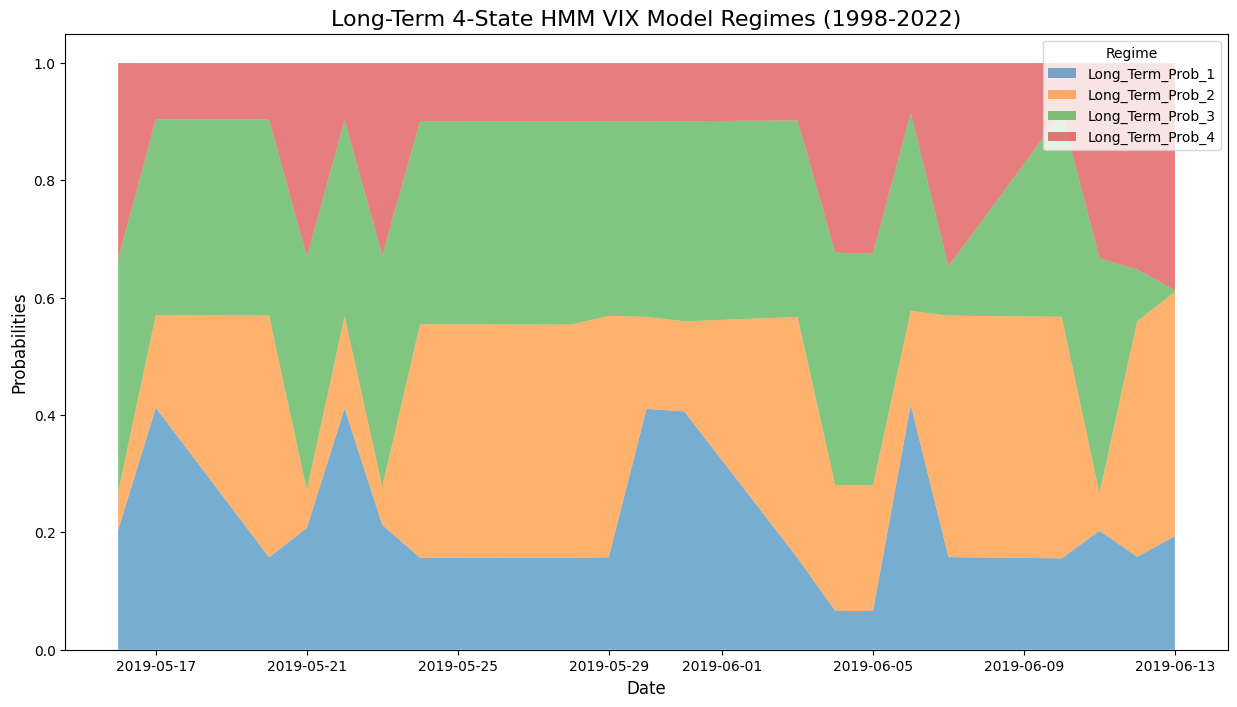

In [192]:
# Plot the long-term probabilities
def plot_long_term_probabilities(results_df):
    print("Data types before plotting:\n", results_df.dtypes)
    print("First few rows of the DataFrame:\n", results_df.head())
    
    plt.figure(figsize=(15, 8))
    
    # Stack plot for long-term probabilities
    labels = [col for col in results_df.columns if col.startswith('Long_Term_Prob_')]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each regime
    plt.stackplot(results_df['Date'], results_df[labels].T, labels=labels, colors=colors, alpha=0.6)
    
    plt.title('Long-Term 4-State HMM VIX Model Regimes (1998-2022)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Probabilities', fontsize=12)
    plt.legend(title='Regime')
    plt.show()

# Ensure the data types are correct
results_df['Date'] = pd.to_datetime(results_df['Date'], errors='coerce')

# Drop NaN values
results_df = results_df.dropna(subset=['Date'])

# Plot
plot_long_term_probabilities(results_df)


In [193]:
results_df

,Date,Expected_Mean,Expected_STD,State_Probs,State_Labels,Long_Term_Prob_1,Long_Term_Prob_2,Long_Term_Prob_3,Long_Term_Prob_4
0,2019-05-16,[-0.894536832610976],[0.7621578439954049],"[3.0181271000212326e-06, 9.000251953917103e-13...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.204121,0.064605,0.397558,0.333715
1,2019-05-17,[-1.4871742414549214],[0.7987979222997003],"[6.733516278282818e-06, 3.2266284680588297e-12...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.412520,0.157775,0.333445,0.096260
2,2019-05-20,[-1.4970453717927676],[0.7990051256483978],"[1.241011543486058e-14, 2.1870060999432713e-06...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.157397,0.412139,0.334072,0.096393
3,2019-05-21,[-0.8951008157625475],[0.7677186083874353],"[5.21346488575323e-05, 2.535635290491191e-10, ...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.207745,0.064282,0.397694,0.330279
4,2019-05-22,[-1.4904842826643756],[0.7997002635230865],"[1.7890793615242014e-05, 3.6630392478421053e-1...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.411366,0.156909,0.334210,0.097514
5,2019-05-23,[-0.9000028642335046],[0.7611503838633273],"[2.0374286039752277e-05, 1.6901811835111326e-1...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.212570,0.065396,0.394193,0.327841
6,2019-05-24,[-1.458751184597826],[0.7947082280368846],"[5.076897961241911e-11, 2.091701203701737e-05,...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.156706,0.398021,0.346401,0.098872
7,2019-05-27,[-1.486315127605286],[0.7891209200880952],"[8.007741156004109e-15, 9.751130810851306e-08,...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.156601,0.397740,0.346218,0.099441
8,2019-05-28,[-1.4861116616274237],[0.7881297299199409],"[3.839630296824435e-14, 5.839825080334853e-07,...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.156590,0.397616,0.346297,0.099497
9,2019-05-29,[-1.4998898472841622],[0.7965955854571981],"[7.047383963874267e-14, 1.3859961447556812e-06...","{0: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.157660,0.411352,0.331994,0.098993


In [149]:
# Convert to DataFrame
results_dfa
= pd.DataFrame({
    'Date': train_rv.index[seed_size:],
    'Expected_Mean': expected_means,
    'Expected_STD': expected_stds,
    'State_Probs': state_probs,
    'Long_Term_Probs': long_term_probs,
    'State_Labels': state_labels_list
})

# Debug print to check the state labels

# Flatten the DataFrame for plotting
results_df = results_df.explode('State_Probs').explode('Long_Term_Probs').reset_index(drop=True)
results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# Debug print to check the final results
results_df[:30]

,Date,Expected_Mean,Expected_STD,State_Probs,Long_Term_Probs,State_Labels,State_Label
0,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.997717,0.338489,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
1,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.997717,0.201209,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
2,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.997717,0.397032,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
3,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.997717,0.06327,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
4,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.000002,0.338489,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
5,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.000002,0.201209,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
6,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.000002,0.397032,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
7,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.000002,0.06327,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
8,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.002281,0.338489,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull
9,2019-05-03,[-0.8857665110289697],[0.76260141097884],0.002281,0.201209,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",Bull


Results DF:
         Date  Expected_Mean  Expected_STD State_Probs  \
0 2019-05-03      -0.885767      0.762601    0.997717   
1 2019-05-03      -0.885767      0.762601    0.997717   
2 2019-05-03      -0.885767      0.762601    0.997717   
3 2019-05-03      -0.885767      0.762601    0.997717   
4 2019-05-03      -0.885767      0.762601    0.000002   
5 2019-05-03      -0.885767      0.762601    0.000002   
6 2019-05-03      -0.885767      0.762601    0.000002   
7 2019-05-03      -0.885767      0.762601    0.000002   
8 2019-05-03      -0.885767      0.762601    0.002281   
9 2019-05-03      -0.885767      0.762601    0.002281   

                                        State_Labels  Long_Term_Prob_1  \
0  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...          0.338489   
1  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...          0.338489   
2  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...          0.338489   
3  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...          0

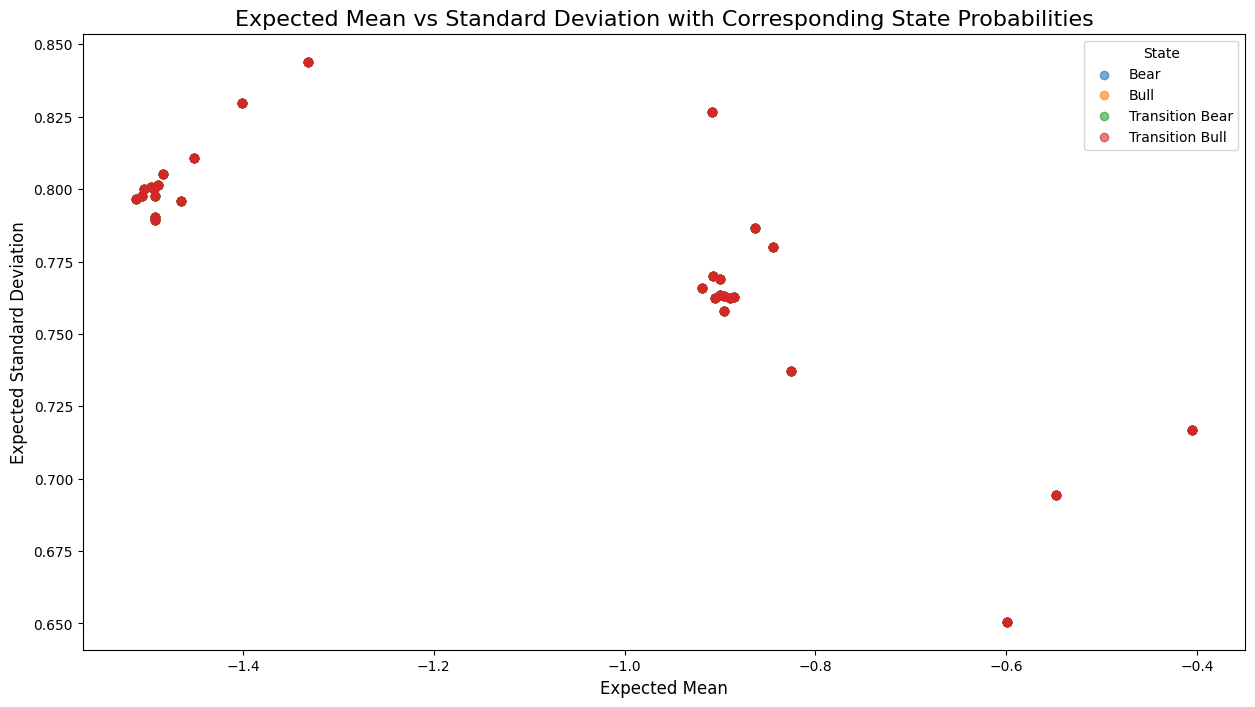

In [137]:
# Flatten 'Expected_Mean' and 'Expected_STD' if they are arrays with a single value
results_df['Expected_Mean'] = results_df['Expected_Mean'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
results_df['Expected_STD'] = results_df['Expected_STD'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# Convert Expected_Mean and Expected_STD to numeric values
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Ensure 'State_Probs' is a list
results_df['State_Probs'] = results_df['State_Probs'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Prepare to explode 'State_Probs' for each state
results_df['State_Labels_List'] = results_df['State_Labels'].apply(lambda x: list(x.items()))

# Explode 'State_Probs' and 'State_Labels_List' for each state
results_df = results_df.explode('State_Probs').explode('State_Labels_List').reset_index(drop=True)

# Extract state index and state label from 'State_Labels_List'
results_df[['State_Index', 'State_Label']] = pd.DataFrame(results_df['State_Labels_List'].tolist(), index=results_df.index)

# Drop the now redundant 'State_Labels_List' column
results_df = results_df.drop(columns=['State_Labels_List'])

# Assign the correct 'State_Label' based on the exploded state index
results_df['State_Label'] = results_df.apply(lambda row: row['State_Label'] if np.argmax(row['State_Probs']) == row['State_Index'] else row['State_Label'], axis=1)

# Drop the 'State_Index' column as it is no longer needed
results_df = results_df.drop(columns=['State_Index'])

# Debug print to check the final results
print("Results DF:\n", results_df.head(10))

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
        plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
    plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
    plt.xlabel('Expected Mean', fontsize=12)
    plt.ylabel('Expected Standard Deviation', fontsize=12)
    plt.legend(title='State')
    plt.show()

# Ensure 'Expected_Mean' and 'Expected_STD' are numeric
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Plot the data
plot_mean_vs_std(results_df)


In [130]:
# Flatten 'Expected_Mean' and 'Expected_STD' if they are arrays with a single value
results_df['Expected_Mean'] = results_df['Expected_Mean'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
results_df['Expected_STD'] = results_df['Expected_STD'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# Convert Expected_Mean and Expected_STD to numeric values
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Ensure 'State_Probs' and 'Long_Term_Probs' are lists
results_df['State_Probs'] = results_df['State_Probs'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Explode 'State_Probs' and 'Long_Term_Probs' for each state
results_df = results_df.explode('State_Probs').reset_index(drop=True)

# # Ensure 'State_Labels' is a dictionary for each row
# results_df['State_Probs'] = results_df['State_Probs'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# # Assign the correct 'State_Label'
# results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# # Debug print to check the final results
# print("Results DF:\n", results_df.head(10))

# # Plot the long-term probabilities
# def plot_long_term_probabilities(results_df):
#     print("Data types before plotting:\n", results_df.dtypes)
#     print("First few rows of the DataFrame:\n", results_df.head())
    
#     plt.figure(figsize=(15, 8))
#     for label, df in results_df.groupby('State_Label'):
#         plt.fill_between(df['Date'], df['Long_Term_Probs'], label=label, alpha=0.6)
    
#     plt.title('Long-Term 4-State HMM VIX Model Regimes (1998-2022)', fontsize=16)
#     plt.xlabel('Date', fontsize=12)
#     plt.ylabel('Probabilities', fontsize=12)
#     plt.legend(title='Regime')
#     plt.show()

# plot_long_term_probabilities(results_df)


In [131]:
results_df

,Date,Expected_Mean,Expected_STD,State_Probs,State_Labels,Long_Term_Prob_1,Long_Term_Prob_2,Long_Term_Prob_3,Long_Term_Prob_4
0,2019-05-03,-0.885767,0.762601,0.997717,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.338489,0.201209,0.397032,0.063270
1,2019-05-03,-0.885767,0.762601,0.000002,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.338489,0.201209,0.397032,0.063270
2,2019-05-03,-0.885767,0.762601,0.002281,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.338489,0.201209,0.397032,0.063270
3,2019-05-03,-0.885767,0.762601,0.0,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.338489,0.201209,0.397032,0.063270
4,2019-05-06,-0.889229,0.762366,0.998904,"{3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...",0.337712,0.201397,0.397571,0.063320
...,...,...,...,...,...,...,...,...,...
115,2019-06-12,-0.908723,0.826635,0.649913,"{2: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",0.401339,0.088482,0.158365,0.351814
116,2019-06-13,-0.825795,0.737354,0.000233,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",0.416288,0.193733,0.387434,0.002545
117,2019-06-13,-0.825795,0.737354,0.0,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",0.416288,0.193733,0.387434,0.002545
118,2019-06-13,-0.825795,0.737354,0.999767,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",0.416288,0.193733,0.387434,0.002545


In [132]:
# Flatten 'Expected_Mean' and 'Expected_STD' if they are arrays with a single value
results_df['Expected_Mean'] = results_df['Expected_Mean'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
results_df['Expected_STD'] = results_df['Expected_STD'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# Convert Expected_Mean and Expected_STD to numeric values
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Ensure 'State_Probs' is a list
results_df['State_Probs'] = results_df['State_Probs'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Prepare to explode 'State_Probs' for each state
results_df['State_Labels_List'] = results_df['State_Labels'].apply(lambda x: list(x.items()))

# Explode 'State_Probs' and 'State_Labels_List' for each state
results_df = results_df.explode('State_Probs').explode('State_Labels_List').reset_index(drop=True)

# Extract state index and state label from 'State_Labels_List'
results_df[['State_Index', 'State_Label']] = pd.DataFrame(results_df['State_Labels_List'].tolist(), index=results_df.index)

# Drop the now redundant 'State_Labels_List' column
results_df = results_df.drop(columns=['State_Labels_List'])

# Assign the correct 'State_Label' based on the exploded state index
results_df['State_Label'] = results_df.apply(lambda row: row['State_Label'] if np.argmax(row['State_Probs']) == row['State_Index'] else row['State_Label'], axis=1)

# Drop the 'State_Index' column as it is no longer needed
results_df = results_df.drop(columns=['State_Index'])

# Debug print to check the final results
print("Results DF:\n", results_df.head(10))

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
   


In [100]:
# Flatten 'Expected_Mean' and 'Expected_STD' if they are arrays with a single value
results_df['Expected_Mean'] = results_df['Expected_Mean'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
results_df['Expected_STD'] = results_df['Expected_STD'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# # Ensure 'Expected_Mean' and 'Expected_STD' are numeric
# results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'], errors='coerce')
# results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'], errors='coerce')

# # Drop NaN values in 'Expected_Mean' and 'Expected_STD'
# results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Debug print to check the state labels
print("State Labels Check:\n", results_df[['Date', 'State_Labels']].head(10))

# Flatten the DataFrame for plotting
results_df = results_df.explode('State_Probs').explode('Long_Term_Probs').reset_index(drop=True)

# Ensure 'State_Labels' are properly populated
print("State Labels after explode:\n", results_df['State_Labels'].head(10))

# Create State_Label column
results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# Debug print after creating State_Label
print("After creating State_Label:\n", results_df.head(10))

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
        plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
    plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
    plt.xlabel('Expected Mean', fontsize=12)
    plt.ylabel('Expected Standard Deviation', fontsize=12)
    plt.legend(title='State')
    plt.show()

# Plot the data
plot_mean_vs_std(results_df)


State Labels Check:
         Date                                       State_Labels
0 2019-05-03  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...
1 2019-05-06  {3: 'Bear', 1: 'Transition Bear', 2: 'Transiti...
2 2019-05-07  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
3 2019-05-08  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
4 2019-05-09  {3: 'Bear', 0: 'Transition Bear', 2: 'Transiti...
5 2019-05-10  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...
6 2019-05-13  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...
7 2019-05-14  {2: 'Bear', 1: 'Transition Bear', 0: 'Transiti...
8 2019-05-15  {1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...
9 2019-05-16  {1: 'Bear', 3: 'Transition Bear', 0: 'Transiti...


KeyError: 'Long_Term_Probs'

In [72]:
# Ensure 'Expected_Mean' and 'Expected_STD' are numeric
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'].apply(lambda x: x[0])) # if isinstance(x, list) else x), errors='coerce')
# results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'].apply(lambda x: x[0] if isinstance(x, list) else x), errors='coerce')

# # Drop NaN values in 'Expected_Mean' and 'Expected_STD'
# results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# # Debug print to check the state labels
# print("State Labels Check:\n", results_df[['Date', 'State_Labels']].head(10))

# # Flatten the DataFrame for plotting
# results_df = results_df.explode('State_Probs').explode('Long_Term_Probs').reset_index(drop=True)

# # Debug print before creating State_Label
# print("Before creating State_Label:\n", results_df.head(10))

# # Create State_Label column
# results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# # Debug print after creating State_Label
# print("After creating State_Label:\n", results_df.head(10))

# # Plot the expected mean vs. standard deviation
# def plot_mean_vs_std(results_df):
#     plt.figure(figsize=(15, 8))
    
#     for label, df in results_df.groupby('State_Label'):
#         plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
#     plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
#     plt.xlabel('Expected Mean', fontsize=12)
#     plt.ylabel('Expected Standard Deviation', fontsize=12)
#     plt.legend(title='State')
#     plt.show()

# # Plot the data
# plot_mean_vs_std(results_df)


TypeError: 'float' object is not subscriptable

In [52]:
results_df = results_df.explode('State_Probs').explode('Long_Term_Probs').reset_index(drop=True)
results_df['State_Label'] = results_df.apply(lambda row: row['State_Labels'][np.argmax(row['State_Probs'])], axis=1)

# Ensure 'Expected_Mean' and 'Expected_STD' are numeric
results_df['Expected_Mean'] = results_df['Expected_Mean'].apply(pd.to_numeric, errors='coerce')
results_df['Expected_STD'] = results_df['Expected_STD'].apply(pd.to_numeric, errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
        plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
    plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
    plt.xlabel('Expected Mean', fontsize=12)
    plt.ylabel('Expected Standard Deviation', fontsize=12)
    plt.legend(title='State')
    plt.show()

# Ensure 'Expected_Mean' and 'Expected_STD' are numeric
results_df['Expected_Mean'] = pd.to_numeric(results_df['Expected_Mean'].apply(lambda x: x[0] if isinstance(x, list) else x), errors='coerce')
results_df['Expected_STD'] = pd.to_numeric(results_df['Expected_STD'].apply(lambda x: x[0] if isinstance(x, list) else x), errors='coerce')

# Drop NaN values in 'Expected_Mean' and 'Expected_STD'
results_df = results_df.dropna(subset=['Expected_Mean', 'Expected_STD'])

# Plot the data
plot_mean_vs_std(results_df)


KeyError: 'Long_Term_Probs'

In [14]:
results_df

,Date,Expected_Mean,Expected_STD,State_Probs,State_Labels,State_Label
0,2019-03-22,[0.03970258259596068],[0.7565764589979044],0.178704,"{1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...",Transition Bull
1,2019-03-22,[0.03970258259596068],[0.7565764589979044],0.011244,"{1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...",Transition Bull
2,2019-03-22,[0.03970258259596068],[0.7565764589979044],0.790982,"{1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...",Transition Bull
3,2019-03-22,[0.03970258259596068],[0.7565764589979044],0.019069,"{1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...",Transition Bull
4,2019-03-25,[-0.9062204458239284],[0.8177996323951177],0.671077,"{1: 'Bear', 2: 'Transition Bear', 0: 'Transiti...",Transition Bull
...,...,...,...,...,...,...
235,2019-06-12,[-0.9322219110890642],[0.8342885196672581],0.649912,"{2: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",Transition Bear
236,2019-06-13,[-0.8485264457829442],[0.7441809983635784],0.000233,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",Transition Bear
237,2019-06-13,[-0.8485264457829442],[0.7441809983635784],0.0,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",Transition Bear
238,2019-06-13,[-0.8485264457829442],[0.7441809983635784],0.999767,"{1: 'Bear', 0: 'Transition Bear', 3: 'Transiti...",Transition Bear


In [17]:
long_term_probs

[array([0.40484742, 0.40484742, 0.40484742, 0.40484742]),
 array([0.25649907, 0.25649907, 0.25649907, 0.25649907]),
 array([0.34157497, 0.34157497, 0.34157497, 0.34157497]),
 array([0.25552716, 0.25552716, 0.25552716, 0.25552716]),
 array([0.32526626, 0.32526626, 0.32526626, 0.32526626]),
 array([0.27726798, 0.27726798, 0.27726798, 0.27726798]),
 array([0.34101043, 0.34101043, 0.34101043, 0.34101043]),
 array([0.09180916, 0.09180916, 0.09180916, 0.09180916]),
 array([0.34001435, 0.34001435, 0.34001435, 0.34001435]),
 array([0.08473876, 0.08473876, 0.08473876, 0.08473876]),
 array([0.08406442, 0.08406442, 0.08406442, 0.08406442]),
 array([0.08453633, 0.08453633, 0.08453633, 0.08453633]),
 array([0.0841457, 0.0841457, 0.0841457, 0.0841457]),
 array([0.09456837, 0.09456837, 0.09456837, 0.09456837]),
 array([0.08772191, 0.08772191, 0.08772191, 0.08772191]),
 array([0.09878605, 0.09878605, 0.09878605, 0.09878605]),
 array([0.33634133, 0.33634133, 0.33634133, 0.33634133]),
 array([0.08753534